In [ ]:
import sys
import os
import nocd
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import normalize
import torch.distributions as td
from scipy import sparse
import math
from tensorflow.keras.optimizers import Adam # - Works
sys.path.append('/GUCD_NCS')


In [ ]:
%matplotlib inline
torch.set_default_tensor_type(torch.cuda.FloatTensor)

__all__ = [
    'BerpoDecoder',
]


class BernoulliDecoder(nn.Module):
    def __init__(self, num_nodes, num_edges, balance_loss=False):
        """Base class for Bernoulli decoder.

        Args:
            num_nodes: Number of nodes in a graph.
            num_edges: Number of edges in a graph.
            balance_loss: Whether to balance contribution from edges and non-edges.
        """
        super().__init__()
        self.num_nodes = num_nodes
        self.num_edges = num_edges
        self.num_possible_edges = num_nodes**2 - num_nodes
        self.num_nonedges = self.num_possible_edges - self.num_edges
        self.balance_loss = balance_loss

    def forward_batch(self, emb, idx):
        """Compute probabilities of given edges.

        Args:
            emb: embedding matrix, shape (num_nodes, emb_dim)
            idx: edge indices, shape (batch_size, 2)

        Returns:
            edge_probs: Bernoulli distribution for given edges, shape (batch_size)
        """
        raise NotImplementedError

    def forward_full(self, emb):
        """Compute probabilities for all edges.

        Args:
            emb: embedding matrix, shape (num_nodes, emb_dim)

        Returns:
            edge_probs: Bernoulli distribution for all edges, shape (num_nodes, num_nodes)
        """
        raise NotImplementedError

    def loss_batch(self, emb, ones_idx, zeros_idx):
        """Compute loss for given edges and non-edges."""
        raise NotImplementedError

    def loss_full(self, emb, adj):
        """Compute loss for all edges and non-edges."""
        raise NotImplementedError


class BerpoDecoder(BernoulliDecoder):
    def __init__(self, num_nodes, num_edges, balance_loss=False):
        super().__init__(num_nodes, num_edges, balance_loss)
        edge_proba = num_edges / (num_nodes**2 - num_nodes)
        self.eps = -np.log(1 - edge_proba)

    def forward_batch(self, emb, idx):
        """Compute probabilities of given edges.

        Args:
            emb: embedding matrix, shape (num_nodes, emb_dim)
            idx: edge indices, shape (batch_size, 2)

        Returns:
            edge_probs: Bernoulli distribution for given edges, shape (batch_size)
        """
        e1, e2 = idx.t()
        logits = torch.sum(emb[e1] * emb[e2], dim=1)
        logits += self.eps
        probs = 1 - torch.exp(-logits)
        return td.Bernoulli(probs=probs)

    def forward_full(self, emb):
        """Compute probabilities for all edges.

        Args:
            emb: embedding matrix, shape (num_nodes, emb_dim)

        Returns:
            edge_probs: Bernoulli distribution for all edges, shape (num_nodes, num_nodes)
        """
        logits = emb @ emb.t()
        logits += self.eps
        probs = 1 - torch.exp(-logits)
        return td.Bernoulli(probs=probs)

    def loss_batch(self, emb, ones_idx, zeros_idx):
        """Compute BerPo loss for a batch of edges and non-edges."""
        print('loss_batch')

        # Loss for edges
        e1, e2 = ones_idx[:, 0], ones_idx[:, 1]
        edge_dots = torch.sum(emb[e1] * emb[e2], dim=1)
        loss_edges = -torch.mean(torch.log(-torch.expm1(-self.eps - edge_dots)))

        # Loss for non-edges
        ne1, ne2 = zeros_idx[:, 0], zeros_idx[:, 1]
        loss_nonedges = torch.mean(torch.sum(emb[ne1] * emb[ne2], dim=1))
        if self.balance_loss:
            neg_scale = 1.0
        else:
            neg_scale = self.num_nonedges / self.num_edges
        return (loss_edges + neg_scale * loss_nonedges) / (1 + neg_scale)

    def loss_full(self, emb, adj):
        """Compute BerPo loss for all edges & non-edges in a graph."""
        print('loss_old')
        e1, e2 = adj.nonzero()
        edge_dots = torch.sum(emb[e1] * emb[e2], dim=1)
        loss_edges = -torch.sum(torch.log(-torch.expm1(-self.eps - edge_dots)))

        # Correct for overcounting F_u * F_v for edges and nodes with themselves
        self_dots_sum = torch.sum(emb * emb)
        correction = self_dots_sum + torch.sum(edge_dots)
        sum_emb = torch.sum(emb, dim=0, keepdim=True).t()
        loss_nonedges = torch.sum(emb @ sum_emb) - correction

        if self.balance_loss:
            neg_scale = 1.0
        else:
            neg_scale = self.num_nonedges / self.num_edges
        return (loss_edges / self.num_edges + neg_scale * loss_nonedges / self.num_nonedges) / (1 + neg_scale)

    def loss_full_new(self, emb, adj):
        """Compute BerPo loss for all edges & non-edges in a graph."""
        e1, e2=adj.coalesce().indices()
        edge_dots = torch.sum(emb[e1] * emb[e2], dim=1)
        adj_list=torch.tensor(adj.coalesce().values().tolist())
        adj_list_log=torch.log(adj_list)
        Lossfunction = nn.L1Loss()
        loss=Lossfunction(edge_dots,adj_list_log)

        return loss


hidden_sizes = [128]    # hidden sizes of the GNN
     # strength of L2 regularization on GNN weights
dropout = 0.5           # whether to use dropout
batch_norm = True       # whether to use batch norm
max_epochs = 5000        # number of epochs to train
display_step = 25       # how often to compute validation loss
balance_loss = True     # whether to use balanced loss
stochastic_loss = True  # whether to use stochastic or full-batch training
batch_size = 20000      # batch size (only for stochastic training)



In [ ]:
from scipy import sparse
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

def GCN_Overlapping(city):
    ###### work
    A = sparse.load_npz(f'/demo_data/A_{city}.npz')
    X = sparse.load_npz(f'/demo_data/X_node2vec_{city}.npz')

    x_norm = normalize(X)  # node features
    x_norm = nocd.utils.to_sparse_tensor(x_norm).cuda()

    N = X.shape[0]
    K = 5

    sampler = nocd.sampler.get_edge_sampler(A, batch_size, batch_size, num_workers=5)
    gnn = nocd.nn.GCN(x_norm.shape[1], hidden_sizes, K, batch_norm=batch_norm, dropout=dropout).cuda()
    adj_norm = gnn.normalize_adj(A)
    decoder = BerpoDecoder(N, A.nnz, balance_loss=balance_loss)

    A_coo = A.tocoo()
    A_tensor = torch.sparse_coo_tensor(torch.LongTensor([A_coo.row, A_coo.col]),
                                       torch.FloatTensor(A_coo.data),
                                       torch.Size(A_coo.shape)).cuda()

    max_epochs = 5000
    weight_decay = 1e-6
    lr = 0.0003
    opt = torch.optim.Adam(gnn.parameters(), lr=lr)

    val_loss = np.inf
    validation_fn = lambda: val_loss
    early_stopping = nocd.train.NoImprovementStopping(validation_fn, patience=100, tolerance=0.01)
    model_saver = nocd.train.ModelSaver(gnn)

    for epoch, batch in enumerate(sampler):
        if epoch > max_epochs:
            break
        if epoch % 100 == 0:
            with torch.no_grad():
                gnn.eval()
                Z = F.relu(gnn(x_norm, adj_norm))
                val_loss = decoder.loss_full_new(Z, A_tensor)
                print(f'Epoch {epoch:4d}, loss.full = {val_loss:.4f}')
                early_stopping.next_step()
                if early_stopping.should_save():
                    model_saver.save()
                if early_stopping.should_stop():
                    print(f'Breaking due to early stopping at epoch {epoch}')
                    break

        gnn.train()
        opt.zero_grad()
        Z = F.relu(gnn(x_norm, adj_norm))
        ones_idx, zeros_idx = batch
        loss = decoder.loss_full_new(Z, A_tensor)
        loss += nocd.utils.l2_reg_loss(gnn, scale=weight_decay)
        loss.backward()
        opt.step()

    plt.hist(Z[Z > 0].cpu().detach().numpy(), 100)
    filename = 'Z_{}.csv'.format(city)
    np.savetxt(filename, Z.cpu().detach().numpy())

    return val_loss, Z, A


In [ ]:
import pandas as pd

#city_list=['Albuquerque', 'Atlanta', 'Austin', 'Bakersfield', 'Baltimore', 'Boston', 'Charlotte', 'Chicago', 'Colorado Springs', 'Columbus', 'Dallas', 'Denver', 'Detroit', 'El Paso', 'Fort Worth', 'Fresno', 'Houston', 'Indianapolis', 'Jacksonville', 'Kansas City', 'Las Vegas', 'Long Beach', 'Los Angeles', 'Louisville+Jefferson County metro government', 'Memphis', 'Mesa', 'Miami', 'Milwaukee', 'Minneapolis', 'Nashville-Davidson metropolitan government', 'Oakland', 'Oklahoma City', 'Omaha', 'Philadelphia', 'Phoenix', 'Portland', 'Raleigh', 'Sacramento', 'San Antonio', 'San Diego', 'San Francisco', 'San Jose', 'Seattle', 'Tampa', 'Tucson', 'Tulsa', 'Virginia Beach', 'Washington', 'Wichita']

city_list=['New York'] ## Take New York City as the demo
results = []
thresh = 0.5

for city in city_list:
    val_loss, Z, A = GCN_Overlapping(city)

    Z_pred = Z.cpu().detach().numpy() > thresh
    metrics = nocd.metrics.evaluate_unsupervised(Z_pred, A)
    result = {
        'city': city,
        'loss': val_loss,
        'coverage': metrics['coverage'],
        'conductance': metrics['conductance'],
        'density': metrics['density'],
        'clustering_coef': metrics['clustering_coef']
    }

    results.append(result)

df_results = pd.DataFrame(results)
df_results.to_csv('city_metrics_results.csv', index=False)

print(df_results)

In [ ]:
thresh = 0.5

Z_pred = Z.cpu().detach().numpy() > thresh
model_saver.restore()

In [ ]:
len(Z_pred)

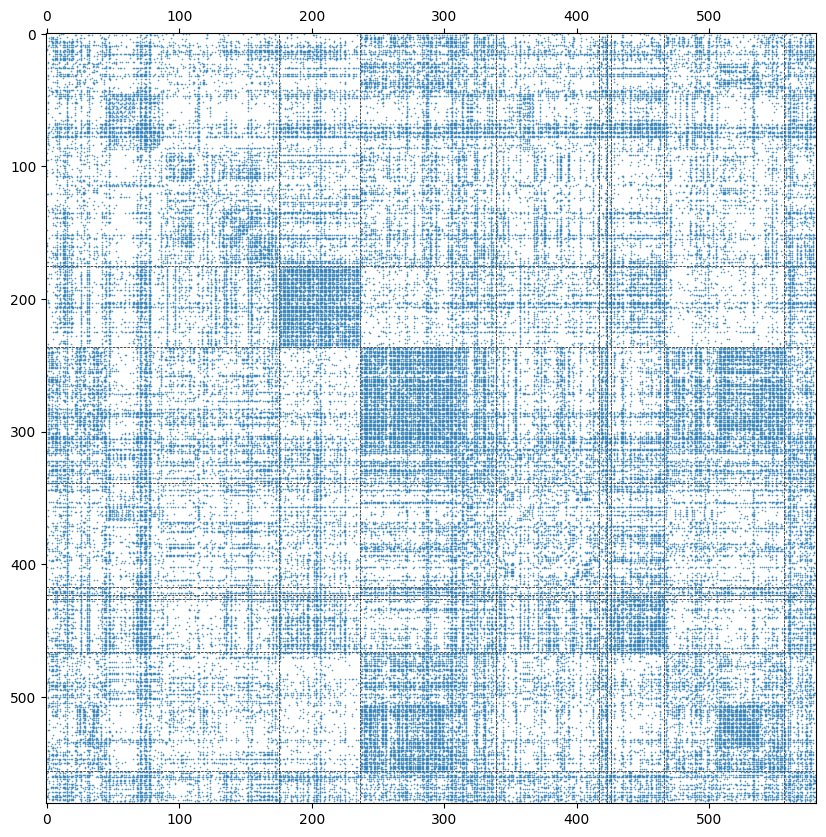

In [ ]:
plt.figure(figsize=[10, 10])
z = np.argmax(Z_pred, 1)
o = np.argsort(z)
nocd.utils.plot_sparse_clustered_adjacency(A, K, z, o, markersize=0.2)

In [ ]:
metrics = nocd.metrics.evaluate_unsupervised(Z_pred, A)
print(f"Predicted communities:\n"
      f" - coverage    = {metrics['coverage']:.4f}\n"
      f" - conductance = {metrics['conductance']:.4f}\n"
      f" - density     = {metrics['density']:.3e}\n"
      f" - clust_coef  = {metrics['clustering_coef']:.3e}")

Predicted communities:
 - coverage    = 0.3812
 - conductance = 0.6881
 - density     = 5.939e-01
 - clust_coef  = 5.554e+04
